In [10]:
from astropy.wcs import WCS
from sqlite3 import connect
from astropy import units as u
from astropy.coordinates import SkyCoord, search_around_sky
from astroquery.vizier import Vizier
import pandas as pd
import sqlite3
import numpy as np
from collections import defaultdict
from os import path
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.patches as plp

import Image_module as im

## Загрузка каталогов

In [11]:
img = im.imread('test.fits') #input("Укажите название снимка или путь к нему:\n")
im_db_path = 'test.db' #input("Укажите каталог снимка или путь к нему:\n")
cat_db_path = 'catalogs.db' 
cat_name = 'ps' #input("Выберите каталог для кросс-сопоставления: ps/sdss\n")
obs_name = 'Maidanak' #input("Выберите название обсерватории")
eps = 1.5 #input("Введите значение epsilon")


w = WCS(img.hdr)

field_center = SkyCoord(*w.wcs.crval, unit = [u.deg, u.deg])
region_width = img.width * (abs(w.wcs.cdelt) * u.deg).to(u.arcsec)[0]
region_height = img.height * (abs(w.wcs.cdelt) * u.deg).to(u.arcsec)[1]

Каталог снимка

In [12]:
if not path.isfile(im_db_path):
        raise IOError(f"No such file \"{im_db_path}\"")
        
con1 = sqlite3.connect(im_db_path)
df1 = pd.read_sql_query("SELECT * from objects", con1)[['ra_deg', 'ra_err', 'dec_deg', 'dec_err', 'mag', 'mag_err']]

df1.rename(columns={df1.columns[0]: 'RA1',
                    df1.columns[1]: 'e_RA1',
                    df1.columns[2]: 'DE1',
                    df1.columns[3]: 'e_DE1',
                    df1.columns[4]: 'r1',
                    df1.columns[5]: 'e_r1'}, inplace=True)

df1['r1'] += 0.21 # R to r magnitude transformation

Внешний каталог

In [13]:
%%time

if not path.isfile(cat_db_path):
        raise IOError(f"No such file \"{cat_db_path}\"")
        
con2 = sqlite3.connect(cat_db_path)

df2 = pd.read_sql_query("SELECT * FROM {} WHERE ({} BETWEEN ? AND ?) AND ({} BETWEEN ? AND ?)".format(cat_name, cat_name + '_RA',cat_name + '_DE'),
                        con2,
                        params = [field_center.ra.value - region_width.value/7200 - 30/3600,
                                  field_center.ra.value + region_width.value/7200 + 30/3600,
                                  field_center.dec.value - region_height.value/7200 - 30/3600,
                                  field_center.dec.value + region_height.value/7200 + 30/3600])

if cat_name == 'ps':  
    
    df2.rename(columns={df2.columns[1]: 'RA2',
                    df2.columns[2]: 'e_RA2',
                    df2.columns[3]: 'DE2',
                    df2.columns[4]: 'e_DE2',
                    df2.columns[5]: 'g2',
                    df2.columns[6]: 'e_g2',
                    df2.columns[7]: 'r2',
                    df2.columns[8]: 'e_r2',
                    df2.columns[9]: 'i2',
                    df2.columns[10]: 'e_i2',
                    df2.columns[11]: 'z2',
                    df2.columns[12]: 'e_z2',
                    df2.columns[13]: 'y2',
                    df2.columns[14]: 'e_y2'}, inplace=True)
else:
    pass

if cat_name == 'sdss':
    
    df2.rename(columns={df2.columns[1]: 'RA2',
                    df2.columns[2]: 'e_RA2',
                    df2.columns[3]: 'DE2',
                    df2.columns[4]: 'e_DE2',
                    df2.columns[5]: 'u2',
                    df2.columns[6]: 'e_u2',
                    df2.columns[7]: 'g2',
                    df2.columns[8]: 'e_g2',
                    df2.columns[9]: 'r2',
                    df2.columns[10]: 'e_r2',
                    df2.columns[11]: 'i2',
                    df2.columns[12]: 'e_i2',
                    df2.columns[13]: 'z2',
                    df2.columns[14]: 'e_z2'}, inplace=True)
else:
    pass

Wall time: 257 ms


In [14]:
loc1 = df2[['RA2', 'e_RA2', 'DE2', 'e_DE2', 'r2', 'e_r2']].dropna() #отсеим объекты без данных о блеске в r фильтре

## Про выборку

С целью создания модели классификации пар объектов по данным о магнитудах в фильтре r, создадим обучающую выборку, представленную двумя классами: первый класс создадим, сопоставляя объекты, которые должны сопоставляться, для формирования второго класса будем устанавливать заведомо неверные сопоставления. Для формирования первого класса отберём пары "объект с изображения (далее - "объект 1") - объект из внешнего каталога (далее - "объект 2")", где для объекта 1 в радиусе 1 угл. сек. нашёлся единственный "объект 2" и притом сопоставление взаимно однозначно (объекту 2 больше не оказался сопоставлен ни один объект 1 с изображения). Второй класс сформируем выбирая объект 1 случайно, и также случайно сопоставляя ему объект 2 из внешнего каталога

In [15]:
coords1 = SkyCoord(df1.iloc[:, 0].values.astype(float), df1.iloc[:, 2].values.astype(float), unit = [u.deg]*2)
coords2 = SkyCoord(loc1.iloc[:, 0].values.astype(float), loc1.iloc[:, 2].values.astype(float), unit = [u.deg]*2)
seplim = 1*u.arcsec
res = search_around_sky(coords1, coords2, seplimit = seplim)

In [26]:
# наблюдение

c1, c2 = np.unique(res[0], return_counts = True)
print("{} объектa/ов со снимка имеют более одного соседа в радиусе {} угл.сек.".format(np.count_nonzero(1*(c2 > 1)), seplim.value, ))

76 объектa/ов со снимка имеют более одного соседа в радиусе 1.0 угл.сек.


Первый класс

In [27]:
a1 = df1.iloc[res[0]]
a1.reset_index(inplace = True, drop=True)

a2 = loc1.iloc[res[1]]
a2.reset_index(inplace = True, drop=True)

class1 = pd.concat([a1, a2], axis = 1)
class1['match'] = 1

# взаимно-однозначное соответствие
class1.drop(index = class1.loc[class1['RA1'].duplicated()].index, inplace = True) 
class1.drop(index = class1.loc[class1['RA2'].duplicated()].index, inplace = True)

Смотр первого класса

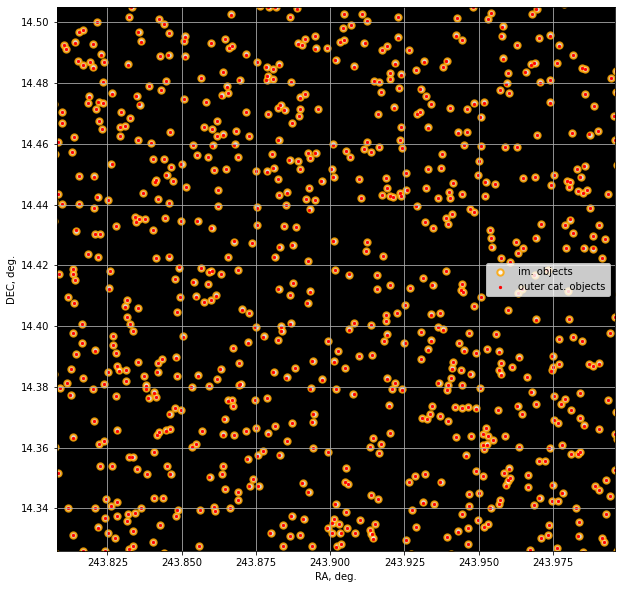

In [28]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(class1['RA1'].values.astype(float), class1['DE1'].values.astype(float), s=40, c='w', label='im. objects', 
                   linewidths = 2,
                   edgecolors = 'orange',
                   alpha=0.85,)

ax.scatter(class1['RA2'].values.astype(float), class1['DE2'].values.astype(float), s=5, color='r', label='outer cat. objects')


ax.set_facecolor('black')
ax.set_xlabel('RA, deg.')
ax.set_ylabel('DEC, deg.')
plt.grid()
plt.legend()

marg=0.2
ax.margins(-marg, -marg)

Второй класс

In [19]:
r1 = np.random.randint(0, len(df1), len(class1)+1)
r2 = np.random.randint(0, len(loc1), len(class1)+1)

b1 = df1.iloc[r1]
b1.reset_index(inplace = True, drop=True)

b2 = loc1.iloc[r2]
b2.reset_index(inplace = True, drop=True)

class2 = pd.concat([b1, b2], axis = 1)
class2['match'] = 0

Проверим распределения угловых расстояний между объектами в сформированных классах. В первом классе установлены верные сопоставления между близкими друг к другу объектами, во втором компаньоны отбирались случайно

In [20]:
import lamy
from importlib import reload
lamy = reload(lamy)

sep1 = class1.apply(lamy.separation, axis = 1)
sep2 = class2.apply(lamy.separation, axis = 1)

Text(0.5, 0.98, 'Распределение угловых расстояний в сопоставленных парах двух классов')

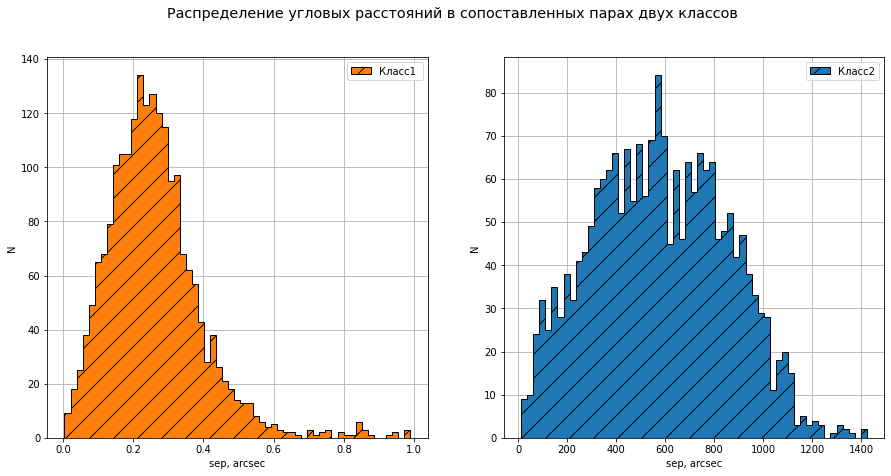

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7))

k1,k2,k3=ax1.hist(sep1, histtype='step', bins=57, label='Класс1 ', color='C1', hatch='/', edgecolor='k', fill=True)
l1,l2,l3=ax2.hist(sep2, histtype='step', bins=57, label='Класс2', hatch='/', edgecolor='k', fill=True)

ax1.grid()
ax2.grid()

ax1.set_xlabel('sep, arcsec')
ax1.set_ylabel('N')

ax2.set_xlabel('sep, arcsec')
ax2.set_ylabel('N')

ax1.legend()
ax2.legend()

fig.suptitle('Распределение угловых расстояний в сопоставленных парах двух классов', fontsize="x-large")
# plt.xlim(-1,150)

Ок

In [30]:
data = pd.concat([class1[['r1', 'e_r1', 'r2', 'e_r2', 'match']], class2[['r1', 'e_r1', 'r2', 'e_r2', 'match']]])
data.reset_index(inplace=True, drop=True)
data

,r1,e_r1,r2,e_r2,match
0,21.020902,0.072360,21.1180,0.0238,1
1,21.705754,0.094620,21.7496,0.0379,1
2,19.619718,0.063758,20.5777,0.0317,1
3,20.940484,0.070367,21.1828,0.0265,1
4,22.548773,0.132576,22.1971,0.1438,1
...,...,...,...,...,...
4100,17.815464,0.093450,21.8556,0.1786,0
4101,16.972361,0.059629,17.0650,0.0031,0
4102,21.310435,0.071361,19.9919,0.0096,0
4103,21.329223,0.074554,19.4540,0.0062,0


## Модель

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


import umap.umap_ as umap
from sklearn.metrics import confusion_matrix, fbeta_score, mean_squared_log_error

In [81]:
X = data.copy()
y = X.pop('match')
X

,r1,e_r1,r2,e_r2
0,21.020902,0.072360,21.1180,0.0238
1,21.705754,0.094620,21.7496,0.0379
2,19.619718,0.063758,20.5777,0.0317
3,20.940484,0.070367,21.1828,0.0265
4,22.548773,0.132576,22.1971,0.1438
...,...,...,...,...
4100,17.815464,0.093450,21.8556,0.1786
4101,16.972361,0.059629,17.0650,0.0031
4102,21.310435,0.071361,19.9919,0.0096
4103,21.329223,0.074554,19.4540,0.0062


Признаки $r_{i}, e_{r_{i}}$ задают доверительные интервалы $r_{i} \pm 3 e_{r_{i}}$ для магнитуд $r$ объектов таблицы, добавим новые признаки, которые смогут помочь модели: 


$X_{1, 2, 3}$ - тот же IoU (Intersection over Union), только для отрезков $[r_{i} - k e_{r_{i}}], k=1, 2, 3$

In [82]:
def IoU(row, k): # k задаёт количество "сигм" в доверительном интервале
    
    a1 = row.r1 - k*row.e_r1
    a2 = row.r1 + k*row.e_r1
    b1 = row.r2 - k*row.e_r2
    b2 = row.r2 + k*row.e_r2
    
    if a1 > b2 or a2 < b1:
        res = 0
        
    else:
        elements = np.sort(np.array((a1, a2, b1, b2)))
        inter = elements[-2] - elements[1]
        union = elements[-1] - elements[0]
        res = inter/union
            
    return res

In [83]:
X_1 = data.apply(IoU, axis=1, args=(1,))
X_2 = data.apply(IoU, axis=1, args=(2,))
X_3 = data.apply(IoU, axis=1, args=(3,))

$X_4$ - кол-во ненулевых IoU в  паре

In [86]:
daframe = pd.DataFrame()
daframe['IoU_1'] = X_1
daframe['IoU_2'] = X_2
daframe['IoU_3'] = X_3

X_4 = daframe[['IoU_1', 'IoU_2', 'IoU_3']].gt(0).sum(axis=1)

$X_5$

In [87]:
X_5 = (X.r1 - X.r2)**2/(2*X.e_r1**2 + 2*X.e_r2**2)

$X_6$ - увеличение IoU (да/нет)

In [89]:
X_6 = 1*(np.round(daframe.IoU_2, 3).gt(np.round(daframe.IoU_1, 3)) | np.round(daframe.IoU_3, 3).gt(np.round(daframe.IoU_2, 3)))

In [90]:
X['f1'] = X_1
X['f2'] = X_2
X['f3'] = X_3
X['f4'] = X_4
X['f5'] = X_5
X['f6'] = X_6
X

,r1,e_r1,r2,e_r2,f1,f2,f3,f4,f5,f6
0,21.020902,0.072360,21.1180,0.0238,0.000000,0.328912,0.328912,2,0.812436,1
1,21.705754,0.094620,21.7496,0.0379,0.400551,0.400551,0.400551,3,0.092522,0
2,19.619718,0.063758,20.5777,0.0317,0.000000,0.000000,0.000000,0,90.506013,0
3,20.940484,0.070367,21.1828,0.0265,0.000000,0.000000,0.090606,1,5.192716,1
4,22.548773,0.132576,22.1971,0.1438,0.000000,0.222328,0.404349,2,1.616447,1
...,...,...,...,...,...,...,...,...,...,...
4100,17.815464,0.093450,21.8556,0.1786,0.000000,0.000000,0.000000,0,200.865754,0
4101,16.972361,0.059629,17.0650,0.0031,0.000000,0.051988,0.051988,2,1.203579,1
4102,21.310435,0.071361,19.9919,0.0096,0.000000,0.000000,0.000000,0,167.665394,0
4103,21.329223,0.074554,19.4540,0.0062,0.000000,0.000000,0.000000,0,314.156949,0


Проверка корреляций

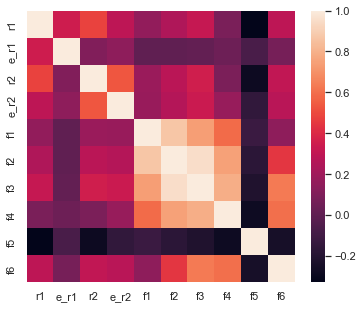

In [100]:
cor = X.corr()

sns.heatmap(cor)
sns.set(rc = {'figure.figsize':(7, 5)})

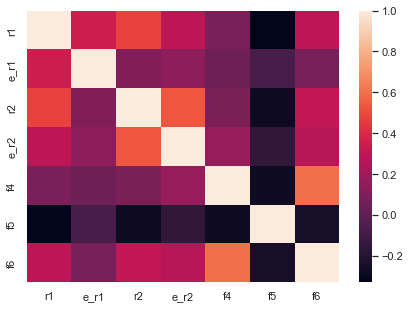

In [110]:
X_upd = X.drop(['f1', 'f2', 'f3'], axis=1)

cor_upd = X_upd.corr()

sns.heatmap(cor_upd)
sns.set(rc = {'figure.figsize':(7, 5)})

In [124]:
X_i=np.array((X_upd))
Y=np.array((y))

Y_i=np.reshape(Y, (len(Y), 1))

sc = StandardScaler()
sc.fit(X_i)
X_i=sc.transform(X_i)

Двумерная визуализация разделимости классов с UMAP

In [126]:
reducer = umap.UMAP()

embedding = reducer.fit_transform(X_i)
umap_df = pd.DataFrame(np.concatenate((embedding, Y_i), axis=1), columns=['component1', 'component2', 'target'])

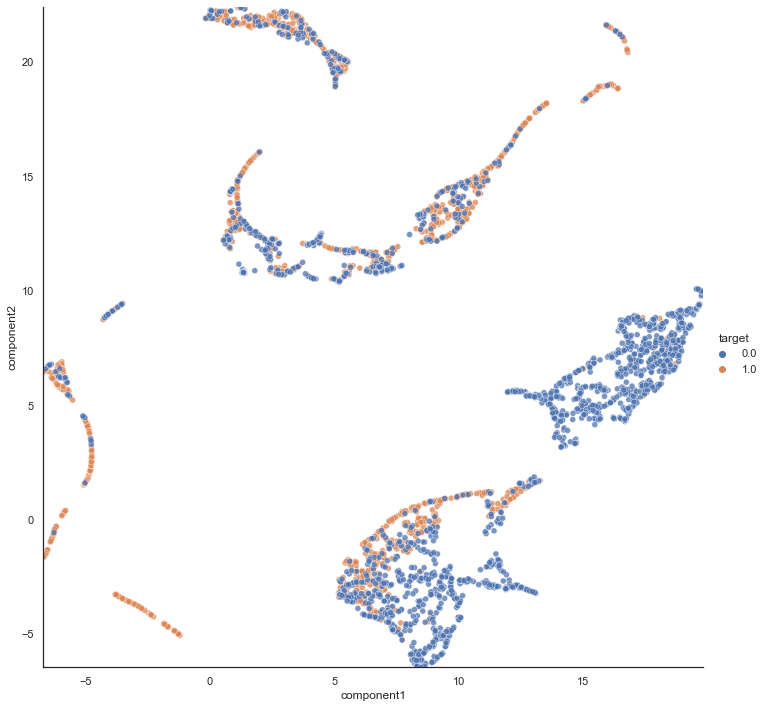

In [131]:
sns.set(rc = {'figure.figsize':(4, 4.5)})
sns.set_theme(style="white")
sns.relplot(x="component1", y="component2", alpha=.75, hue="target", data=umap_df, height=10)
# plt.ylim(-7, 7)
# plt.xlim(-5, 5)

marg=0
plt.margins(-marg, -marg)

Учимся

In [140]:
X_train, X_test, Y_train, Y_test = train_test_split(X_i, Y, test_size=.25, random_state=47)

In [134]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

ml_svm = svm.SVC(kernel='rbf', probability=True) 

# logreg=LogisticRegression()
# knn = KNeighborsClassifier()

fbeta_scorer = make_scorer(fbeta_score, beta=.5, pos_label=1) 

In [138]:
# search_space_poly = {'C': [0.1, 1, 10],
#               'kernel': ['poly'],
#               'gamma': [0.1, 1, 10],
#               'degree': [3]} 

# search_space_knn = {'n_neighbors': list(range(1, 6)),
#                  'weights': ['uniform', 'distance'],
#                  'metric': ['minkowski','euclidean', 'manhattan']}

# search_space_logreg={'C': [0.0001, 0.001, 0.01, 0.1, 1],
#               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#               'penalty': ['l1', 'l2', 'elasticnet'],}

In [143]:
search_space_rbf = {'C': [1, 10], 
              'gamma': [20, 30, 40],
              'kernel': ['rbf']} 

grid = GridSearchCV(ml_svm, search_space_rbf, refit=True, verbose = 3, cv=5, scoring=fbeta_scorer)
grid_search=grid.fit(X_train, Y_train)
print(grid_search.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .........C=1, gamma=20, kernel=rbf;, score=0.847 total time=   1.3s
[CV 2/5] END .........C=1, gamma=20, kernel=rbf;, score=0.841 total time=   1.3s
[CV 3/5] END .........C=1, gamma=20, kernel=rbf;, score=0.841 total time=   1.3s
[CV 4/5] END .........C=1, gamma=20, kernel=rbf;, score=0.831 total time=   1.2s
[CV 5/5] END .........C=1, gamma=20, kernel=rbf;, score=0.820 total time=   1.2s
[CV 1/5] END .........C=1, gamma=30, kernel=rbf;, score=0.851 total time=   1.4s
[CV 2/5] END .........C=1, gamma=30, kernel=rbf;, score=0.845 total time=   1.4s
[CV 3/5] END .........C=1, gamma=30, kernel=rbf;, score=0.846 total time=   1.4s
[CV 4/5] END .........C=1, gamma=30, kernel=rbf;, score=0.840 total time=   1.5s
[CV 5/5] END .........C=1, gamma=30, kernel=rbf;, score=0.822 total time=   1.5s
[CV 1/5] END .........C=1, gamma=40, kernel=rbf;, score=0.848 total time=   1.6s
[CV 2/5] END .........C=1, gamma=40, kernel=rbf;,

In [144]:
Y_pred = grid.predict(X_test)

fbeta_score(Y_test.tolist(), Y_pred.tolist(), beta = .5)

0.8562874251497006

In [145]:
cf_matrix = confusion_matrix(Y_test.tolist(), Y_pred.tolist())
cf_matrix

array([[436,  66],
       [ 96, 429]], dtype=int64)

XGBoost

In [146]:
model = XGBClassifier()
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [147]:
fbeta_score(Y_test.tolist(), model.predict(X_test).tolist(), beta = .5)

0.8644946316179191

RandomForest

In [148]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, Y_train)


RandomForestClassifier(random_state=0)

In [149]:
fbeta_score(Y_test.tolist(), clf.predict(X_test).tolist(), beta = .5)

0.8552388004442799

In [151]:
cf_matrix = confusion_matrix(Y_test.tolist(), clf.predict(X_test).tolist())
cf_matrix

array([[420,  82],
       [ 63, 462]], dtype=int64)

Тюнинг гиперпараметров впереди

Ctrl+s

In [68]:
import joblib

joblib.dump(grid, obs_name + ".save") 

['Maidanak.save']